In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('train.tsv', sep='\t')

df = df [:3000]

train, test = train_test_split(df, test_size=0.20)

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import torch

vectorizer = CountVectorizer(binary=True)
text_data = train["Phrase"]
text_data = vectorizer.fit_transform(text_data)

text_tensor_train = torch.from_numpy(text_data.todense()).float()

text_tensor_train = text_tensor_train.unsqueeze(1)

#ajout du cas où on ne connait pas le mot
voca = vectorizer.get_feature_names() #+ list(['<unk>'])
#ajout d'un zéro à la fin de chaque tensor
# unk = torch.zeros([text_tensor_train.shape[0],1], dtype=torch.float)
# text_tensor_train = torch.cat((text_tensor_train, unk), 1).unsqueeze(1)

def labelToVec(label):
    # label_one_hot_vector = torch.tensor(pd.get_dummies(df["Sentiment"]).values)
    label_tensor = torch.tensor(label["Sentiment"].values)
    return label_tensor

label_tensor_train = labelToVec(train)

In [3]:
from nltk import word_tokenize
# nltk.download('punkt')

def vocaToUnk(sentence, voca):
    s = []
    for w in word_tokenize(sentence):
        if(w not in voca):
            w = '<unk>'
        s.append(w)
    return " ".join(s)         
                
# text_test = test.Phrase.apply(lambda x : vocaToUnk(x, voca))
#Ne prend pas en compte <unk>
text_test = vectorizer.transform(test["Phrase"])

text_tensor_test = torch.from_numpy(text_test.todense()).float()
label_tensor_test = labelToVec(test)

text_tensor_test = text_tensor_test.unsqueeze(1)

In [4]:
print(text_tensor_test[1], text_tensor_train[0])

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, embedding_size)

        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.h2o = nn.Linear(hidden_size, output_size)       
        
    def forward(self, input, hidden):
        
        hidden = hidden.to(device)
        output, hidden = self.rnn(input, hidden)
        output = self.h2o(hidden)
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, dtype=torch.float)

In [7]:
input_dim = len(voca)
embedding_size = 100
hidden_dim = 100
output_dim = 5

rnn = RNN(input_dim, embedding_size, hidden_dim, output_dim)

import torch.optim as optim

optimizer = optim.SGD(rnn.parameters(), lr=1e-3)

def trainRNN(train_category, train_text, test_category, test_text, num_epoch, batch_size):
    
    train_category = train_category.to(device)
    train_text = train_text.to(device)
    test_category = test_category.to(device)
    test_text = test_text.to(device)
    
    size_train = train_text.size(0)
    size_test = test_text.size(0)
    
    hidden = rnn.initHidden(batch_size)   
    criterion = nn.CrossEntropyLoss()    
    rnn.zero_grad()
    
    total_pred = torch.tensor([], dtype = torch.long)
    total_targ = torch.tensor([], dtype = torch.long)
    
    for epoch in range(num_epoch):
        #un jour je ferais un truc propre
        nb_batch_train = len(train_text) / batch_size
        nb_batch_test = len(test_text) / batch_size
        train_loss = 0
        train_acc = 0
        i = 0
        while (i + batch_size) <= size_train:
            tmp = i
            i += batch_size
            input = train_text[tmp:i]
            target = train_category[tmp:i]
            output, hidden = rnn(input, hidden)
            
            loss = criterion(output.squeeze(0), target)
            loss.backward(retain_graph=True)
            optimizer.step() 
            
            predicted = torch.argmax(output.data, dim=2)
            correct = (predicted == target).sum().item()
            
            train_loss += loss.item()
            train_acc += correct / batch_size
        
        i = 0
        test_loss = 0
        test_acc = 0        
        
        #j'aime faire des boucles presque pareilles
        while (i + batch_size) <= size_test:
            tmp = i
            i += batch_size
            input = test_text[tmp:i]
            target = test_category[tmp:i]
            
            output, _ = rnn(input, hidden)
            loss = criterion(output.squeeze(0), target)   
            
            predicted = torch.argmax(output.data, dim=2)
            correct = (predicted == target).sum().item()
            
            test_loss += loss.item()
            test_acc += correct / batch_size
            
            #dernière epoch
            if epoch + 1 == num_epoch:
                total_pred = torch.cat((total_pred, predicted), 1)
                total_targ = torch.cat((total_targ, target), 0)
                
        print(epoch, "loss :", train_loss / nb_batch_train, "/ acc :", train_acc / nb_batch_train)
        print("Test loss :", test_loss / nb_batch_test, "/ acc :", test_acc / nb_batch_test)
        
    print('Fini !')
    
    return total_pred, total_targ

In [8]:
batch_size = 50
nb_epoch = 5

pred, real = trainRNN(label_tensor_train, text_tensor_train, label_tensor_test, text_tensor_test, nb_epoch, batch_size)

0 loss : 1.397036850452423 / acc : 0.5291666666666668
Test loss : 1.2240630934635799 / acc : 0.585
1 loss : 1.211579106748104 / acc : 0.6125
Test loss : 1.2347112099329631 / acc : 0.5866666666666667
2 loss : 1.126040695856015 / acc : 0.61375
Test loss : 1.236247147123019 / acc : 0.585
3 loss : 1.1351089005668957 / acc : 0.6120833333333334
Test loss : 1.2770091990629833 / acc : 0.5249999999999999
4 loss : 1.5957910145322483 / acc : 0.5175
Test loss : 1.4466505646705627 / acc : 0.585
Fini !


In [9]:
from sklearn.metrics import confusion_matrix
from pandas_ml import ConfusionMatrix

print(train.groupby('Sentiment')["Sentiment"].count())
print(test.groupby('Sentiment')["Sentiment"].count())

#warning chiante, mais np
cm = ConfusionMatrix(real.data, pred.squeeze(0).data)
confusion_matrix(real, pred.squeeze(0))

Sentiment
0      71
1     384
2    1470
3     368
4     107
Name: Sentiment, dtype: int64
Sentiment
0     22
1     93
2    351
3     95
4     39
Name: Sentiment, dtype: int64


/home/noadkoko/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


array([[  0,   0,  22,   0,   0],
       [  0,   0,  93,   0,   0],
       [  0,   0, 351,   0,   0],
       [  0,   0,  95,   0,   0],
       [  0,   0,  39,   0,   0]])

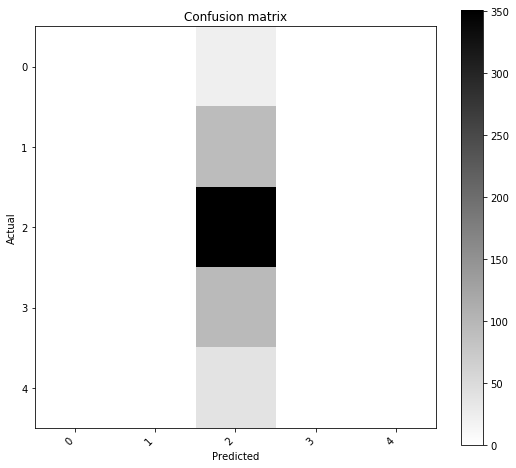

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

cm.plot()
plt.show()